In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import arviz as az

In [2]:
SEEDS = 1000
Z_MAX = 5

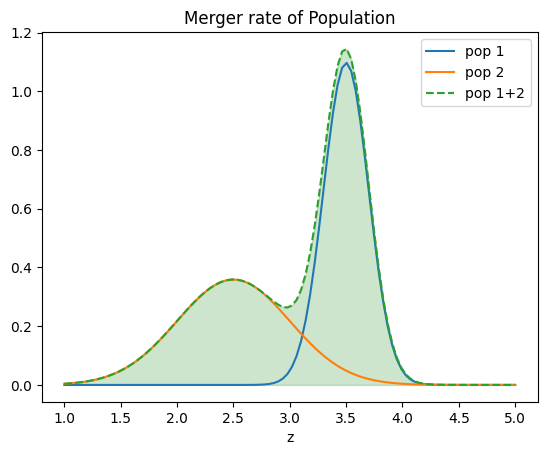

In [3]:
A = .55
MU_A = 3.5
MU_B = 2.5
SIGMA_A = .2
SIGMA_B = .5

merger_rate_A = lambda z : A * st.norm.pdf(x=z, loc=MU_A, scale=SIGMA_A)
merger_rate_B = lambda z : (1 - A) * st.norm.pdf(x=z, loc=MU_B, scale=SIGMA_B)
total_merger_rate = lambda z : merger_rate_A(z) + merger_rate_B(z)

# TESTING DISTRIBUTIONS

z = np.linspace(1, Z_MAX, 100)
plt.plot(z, merger_rate_A(z), label='pop 1')
plt.plot(z, merger_rate_B(z), label='pop 2')
plt.plot(z, total_merger_rate(z), label='pop 1+2', linestyle='--')
plt.fill_between(z,total_merger_rate(z), color='green', alpha=.2)
plt.legend()
plt.xlabel('z')
plt.title('Merger rate of Population')
del z

Text(0, 0.5, '$d^2N^s_\\uparrow/dzdt$')

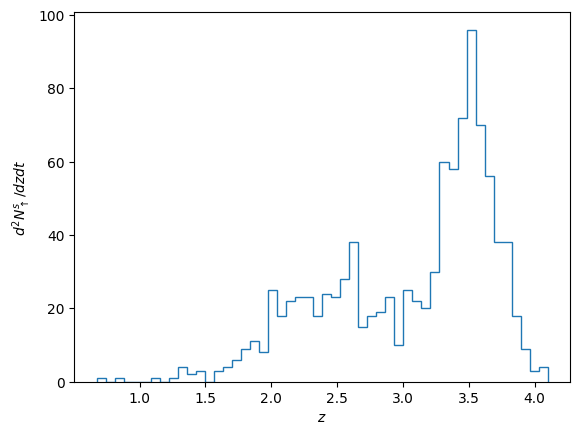

In [4]:
# DISTRIBUTION FOR SOURCE DETECTION

z_events = np.random.choice(np.linspace(0, Z_MAX, SEEDS), size=SEEDS, p=total_merger_rate(np.linspace(0, Z_MAX, SEEDS)) / np.sum(total_merger_rate(np.linspace(0, Z_MAX, SEEDS))))
# check the plot with the true distribution
plt.hist(z_events, bins=50, fill=False, histtype='step')
plt.xlabel('$z$')
plt.ylabel('$d^2N^s_\\uparrow/dzdt$')

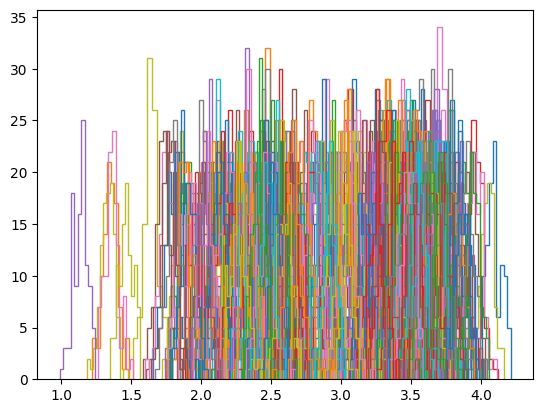

In [5]:
# DEFINING THE POSTERIORS ON Z

LEN_DATA = 100
Z_SRC = np.empty((SEEDS, LEN_DATA))
for i in range(SEEDS):
    Z_SRC[i] = st.norm(loc=z_events[i], scale=0.05).rvs(size=LEN_DATA)

# PLOTTING ALL THE EVENTS' Z

for i in range(SEEDS//2):
    plt.hist(Z_SRC[i], fill=False, histtype='step', label=i)

In [6]:
import pymc3 as pm

In [7]:
with pm.Model() as model:
    
    frac_A = pm.Uniform('A', lower=A-.5, upper=A+.5)
    frac_B = pm.Uniform('B', lower=(1-A)-.5, upper=(1-A)+.5)

    mu_A = pm.Uniform('MU_A', lower=MU_A-1, upper=MU_A+1)
    sigma_A = pm.Uniform('SIGMA_A', lower=SIGMA_A-1, upper=SIGMA_A+1)
    mu_B = pm.Uniform('MU_B', lower=MU_B-1, upper=MU_B+1)
    sigma_B = pm.Uniform('SIGMA_B', lower=SIGMA_B-1, upper=SIGMA_B+1)

    prior = frac_A * pm.Normal('mu_A', mu=mu_A, sigma=sigma_A) + frac_B * pm.Normal('mu_B', mu=mu_B, sigma=sigma_B)
    #prior = frac_A * pm.Normal('mu_A', mu=mu_A, sigma=sigma_A)
    
    obs = pm.Normal('obs', mu=prior, sigma=0.05, observed=Z_SRC)  # likelihood draws data points from prior
 
    # sample with 3 independent Markov chains
    
    trace_METROPOLIS = pm.sample(draws=500, chains=5, step=pm.Metropolis(), return_inferencedata=True, cores=5)
    #trace_NUTS = pm.sample(draws=500, chains=2, step=pm.NUTS(), return_inferencedata=True)

Multiprocess sampling (5 chains in 5 jobs)
CompoundStep
>Metropolis: [mu_B]
>Metropolis: [mu_A]
>Metropolis: [SIGMA_B]
>Metropolis: [MU_B]
>Metropolis: [SIGMA_A]
>Metropolis: [MU_A]
>Metropolis: [B]
>Metropolis: [A]


/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 5 chains for 1_000 tune and 500 draw iterations (5_000 + 2_500 draws total) took 3 seconds.
The rhat statistic 

In [8]:
az.summary(trace_METROPOLIS, var_names=["A", "B", "MU_A", "MU_B", "SIGMA_A", "SIGMA_B"])
#az.summary(trace_NUTS, var_names=["A", "B", "MU_A", "MU_B", "SIGMA_A", "SIGMA_B"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,0.550,0.001,0.549,0.551,0.000,0.000,6.0,37.0,2.32
B,0.451,0.001,0.449,0.454,0.001,0.000,6.0,12.0,3.03
MU_A,3.490,0.413,2.676,4.303,0.020,0.014,423.0,405.0,1.03
MU_B,2.479,0.408,1.678,3.269,0.019,0.013,467.0,353.0,1.02
SIGMA_A,0.538,0.336,0.025,1.103,0.026,0.019,138.0,110.0,1.03
SIGMA_B,0.662,0.422,0.020,1.372,0.031,0.022,150.0,115.0,1.02


array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'B'}>, <Axes: title={'center': 'B'}>],
       [<Axes: title={'center': 'MU_A'}>,
        <Axes: title={'center': 'MU_A'}>],
       [<Axes: title={'center': 'MU_B'}>,
        <Axes: title={'center': 'MU_B'}>],
       [<Axes: title={'center': 'SIGMA_A'}>,
        <Axes: title={'center': 'SIGMA_A'}>],
       [<Axes: title={'center': 'SIGMA_B'}>,
        <Axes: title={'center': 'SIGMA_B'}>]], dtype=object)

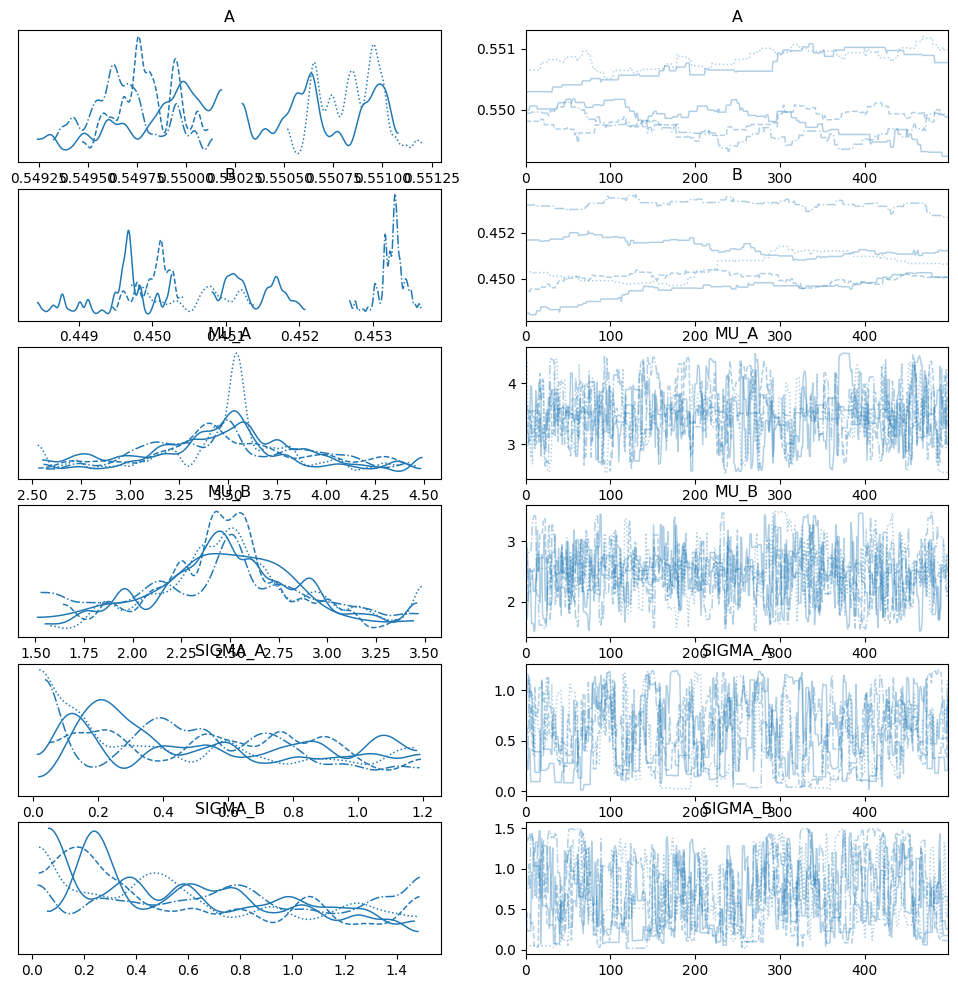

In [9]:
az.plot_trace(trace_METROPOLIS, var_names=("A", "B", "MU_A", "MU_B", "SIGMA_A", "SIGMA_B"))
#az.plot_trace(trace_NUTS, var_names=("A", "B", "MU_A", "MU_B", "SIGMA_A", "SIGMA_B"))

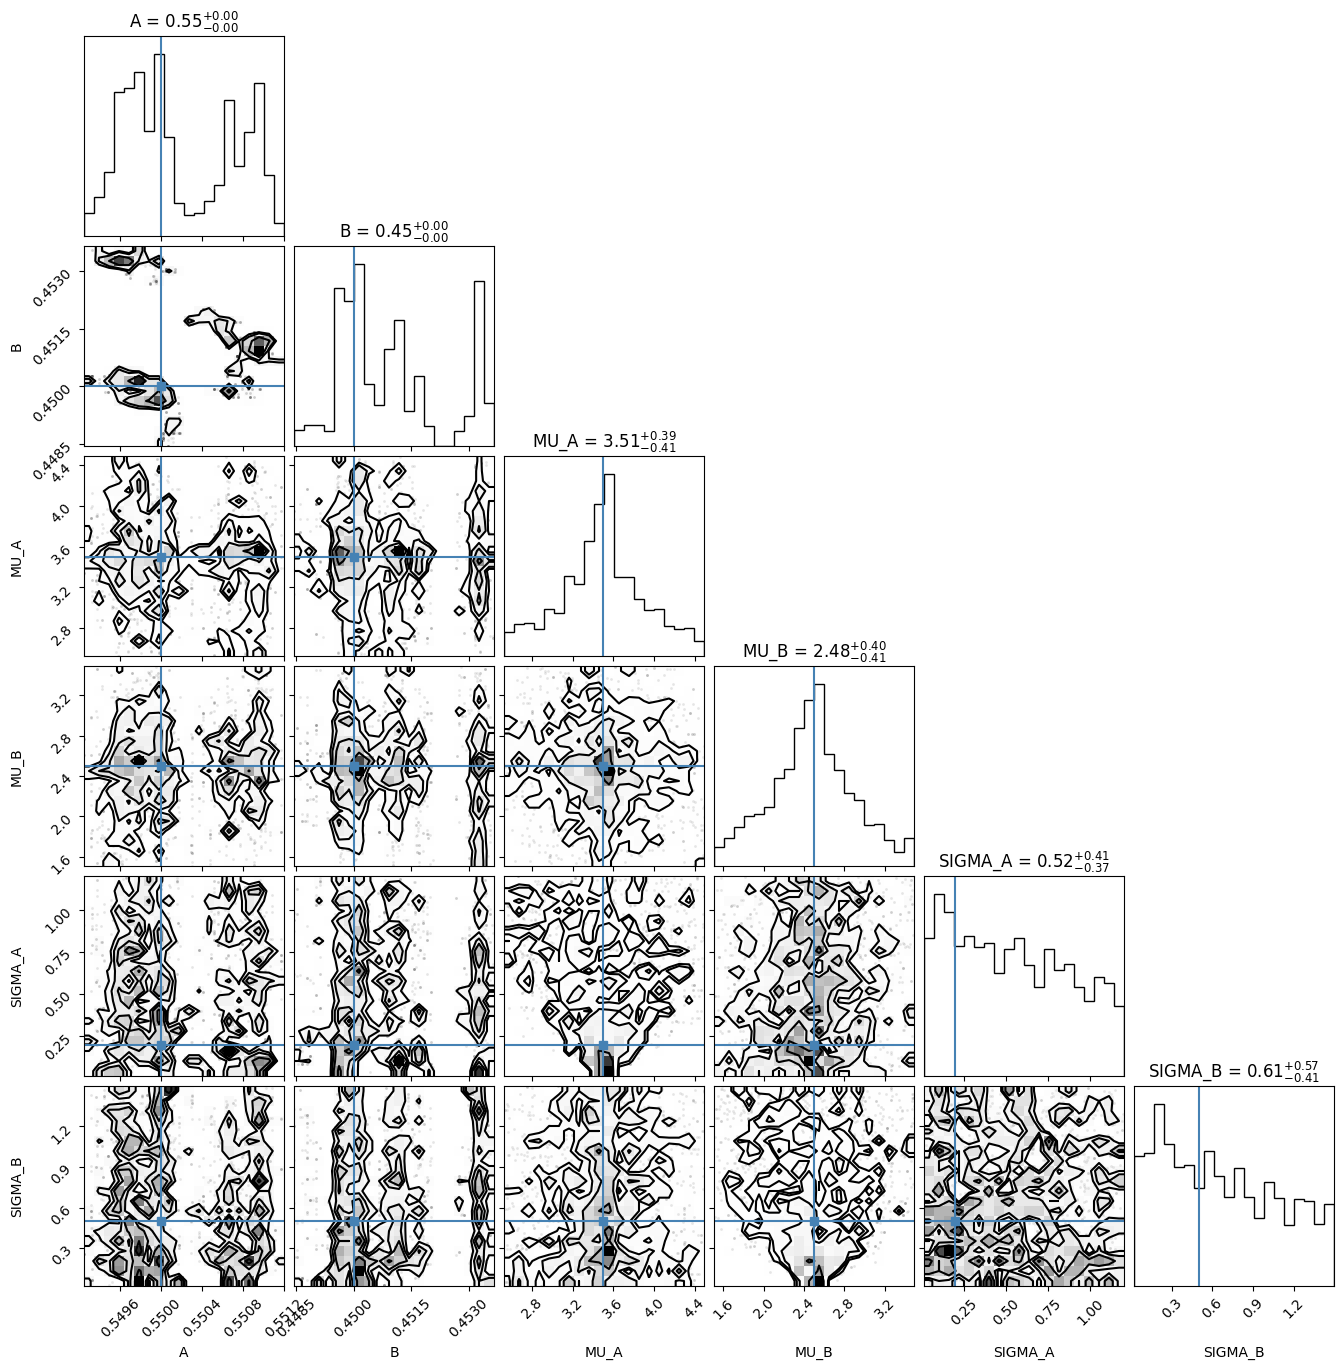

In [10]:
import corner
_ = corner.corner(trace_METROPOLIS, var_names=["A", "B", "MU_A", "MU_B", "SIGMA_A", "SIGMA_B"], 
                  truths=dict(A=A, B=1-A, MU_A=MU_A, MU_B=MU_B, SIGMA_A=SIGMA_A, SIGMA_B=SIGMA_B), show_titles=True)
#_ = corner.corner(trace_NUTS, var_names=["A", "B", "MU_A", "MU_B", "SIGMA_A", "SIGMA_B"])